# EDA, Missingness and Hypothesis Analysis of Congressmember Stock Trades

**Kevin Morales Nguyen - A17186624**

## Summary of Findings

### Introduction
This dataset primarily contains information relating to stock trades made by members of the US congress.
The majority of the data is categorical which had great impact on how to approach analysis. This analysis is primarily focused in inquiring further about how party affilition is related to various other variables part of transactions.

### Cleaning and EDA
It was observed that the owner variable had many values missing and the missingness mechanism was to be further explored. Cleaning involved converting the dates formating to timestamps, making sure to replace user nan values with appropriate nan values for analysis. The data cleaning also involved manual cleanup of representative names in order to merge with a second dataset that contained party affiliation which was not part of the original dataset. EDA revealed that the two biggest stocks held amongst both republicans and democrats was Apple and Microsoft, further exploration showed that republicans tended to trade older technology and traditional energy companies compared to democrats who traded newer technology, solar energy and large holdings companies. Within the data set it was observed that democrats traded about 63% of the trades and republicans made up 36% of the trades, further more when analysing the amount traded by party it was found that democrats engaged in many more high usd value trades that were at or exceeded $500,000. 

### Assessment of Missingness
It was found that the Owner variable may be NMAR, but MAR permutation testing showed that the missingness of owner is in fact MAR dependent on amount, type, and party variables.

### Hypothesis Test
When hypothesizing about the proportion of trades based on party affiliation, a null hypothesis in which party affiliates traded at equal proportions was rejected in favor of a alternative hypothesis that democrats tend to initiate more trades than republicans.


## Code

In [207]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import requests
import bs4

### Cleaning and EDA

Load the data and take an initial look

In [208]:
raw_data = pd.read_csv('all_transactions.csv')
raw_data.head()

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,ptr_link,cap_gains_over_200_usd
0,2021,10/04/2021,2021-09-27,joint,BP,BP plc,purchase,"$1,001 - $15,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False
1,2021,10/04/2021,2021-09-13,joint,XOM,Exxon Mobil Corporation,purchase,"$1,001 - $15,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False
2,2021,10/04/2021,2021-09-10,joint,ILPT,Industrial Logistics Properties Trust - Common...,purchase,"$15,001 - $50,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False
3,2021,10/04/2021,2021-09-28,joint,PM,Phillip Morris International Inc,purchase,"$15,001 - $50,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False
4,2021,10/04/2021,2021-09-17,self,BLK,BlackRock Inc,sale_partial,"$1,001 - $15,000",Hon. Alan S. Lowenthal,CA47,https://disclosures-clerk.house.gov/public_dis...,False


Okay merging political party on names might be a good idea, let's get clean up names column by removing 'Hon.' from all names, also by deafult if there was no value in csv is was loaded into dataframe with np.nan float
but some values were loaded with '--' so let's change those to np.nan floats across all columns and rows and lets check to make sure all columns have appropriate data

In [299]:
raw_data = pd.read_csv('all_transactions.csv')
#raw_data

raw_data['representative'] = raw_data['representative']
    .apply(lambda x: x.replace('Hon. ',''))
#raw_data[:50]
                  
raw_data_nan = raw_data.replace('--',np.nan)
#raw_data_nan['ticker'].value_counts()

The transaction_date has a different format to where we can't just easily convert it to timestamp so we let's make a helper function to prep is to that we can call to_datetime on cleaned series

In [210]:
def convert_date(x):
    return x[5:7] + '/' + x[8:] + '/' + x[0:4]

Convert the transaction and discolse dates to timestamps

In [211]:
raw_data_nan['disclosure_date'] = pd.to_datetime(
    raw_data_nan['disclosure_date'])


raw_data_nan['transaction_date'] = raw_data_nan['transaction_date']
    .apply(convert_date)
raw_data_nan['transaction_date'] = pd.to_datetime(
    raw_data_nan['transaction_date'])
raw_data_nan
#raw_data_nan['transaction_date'] = pd.to_datetime(raw_data_nan['transaction_date'])
#raw_data_nan

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,ptr_link,cap_gains_over_200_usd
0,2021,2021-10-04,2021-09-27,joint,BP,BP plc,purchase,"$1,001 - $15,000",Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False
1,2021,2021-10-04,2021-09-13,joint,XOM,Exxon Mobil Corporation,purchase,"$1,001 - $15,000",Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False
2,2021,2021-10-04,2021-09-10,joint,ILPT,Industrial Logistics Properties Trust - Common...,purchase,"$15,001 - $50,000",Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False
3,2021,2021-10-04,2021-09-28,joint,PM,Phillip Morris International Inc,purchase,"$15,001 - $50,000",Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False
4,2021,2021-10-04,2021-09-17,self,BLK,BlackRock Inc,sale_partial,"$1,001 - $15,000",Alan S. Lowenthal,CA47,https://disclosures-clerk.house.gov/public_dis...,False
...,...,...,...,...,...,...,...,...,...,...,...,...
14269,2020,2020-06-10,2020-04-09,NaN,SWK,"Stanley Black & Decker, Inc.",sale_partial,"$1,001 - $15,000",Ed Perlmutter,CO07,https://disclosures-clerk.house.gov/public_dis...,False
14270,2020,2020-06-10,2020-04-09,NaN,USB,U.S. Bancorp,sale_partial,"$1,001 - $15,000",Ed Perlmutter,CO07,https://disclosures-clerk.house.gov/public_dis...,False
14271,2020,2020-06-10,2020-03-13,NaN,BMY,Bristol-Myers Squibb Company,sale_full,"$100,001 - $250,000",Nicholas Van Taylor,TX03,https://disclosures-clerk.house.gov/public_dis...,False
14272,2020,2020-06-10,2020-03-13,NaN,LLY,Eli Lilly and Company,sale_full,"$500,001 - $1,000,000",Nicholas Van Taylor,TX03,https://disclosures-clerk.house.gov/public_dis...,False


Let's go over a couple columns and check values to make sure different forms of nans aren't showing up

In [216]:
print(raw_data_nan['disclosure_year'].value_counts())
print('sum:', raw_data_nan['disclosure_year'].value_counts().sum())

2020    7379
2021    5520
2022    1375
Name: disclosure_year, dtype: int64
sum: 14274


Overall data types, leaving disclosure year as int seems fine because it can be used as a broad categorial variable, more refined data with months and days have been converted to datetimes, the rest are fine as strings in cludeing amount. The amount has a coarse granularity because it only captures ranges no a specific monetary amount so we will have to use it as a categorical variable. We could extract days and months for further accuracy if we want.

In [217]:
raw_data_nan.dtypes

disclosure_year                    int64
disclosure_date           datetime64[ns]
transaction_date          datetime64[ns]
owner                             object
ticker                            object
asset_description                 object
type                              object
amount                            object
representative                    object
district                          object
ptr_link                          object
cap_gains_over_200_usd              bool
dtype: object

Verify datetime data type

In [218]:
raw_data_nan['disclosure_date'][0]

Timestamp('2021-10-04 00:00:00')

In [219]:
raw_data_nan

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,ptr_link,cap_gains_over_200_usd
0,2021,2021-10-04,2021-09-27,joint,BP,BP plc,purchase,"$1,001 - $15,000",Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False
1,2021,2021-10-04,2021-09-13,joint,XOM,Exxon Mobil Corporation,purchase,"$1,001 - $15,000",Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False
2,2021,2021-10-04,2021-09-10,joint,ILPT,Industrial Logistics Properties Trust - Common...,purchase,"$15,001 - $50,000",Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False
3,2021,2021-10-04,2021-09-28,joint,PM,Phillip Morris International Inc,purchase,"$15,001 - $50,000",Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False
4,2021,2021-10-04,2021-09-17,self,BLK,BlackRock Inc,sale_partial,"$1,001 - $15,000",Alan S. Lowenthal,CA47,https://disclosures-clerk.house.gov/public_dis...,False
...,...,...,...,...,...,...,...,...,...,...,...,...
14269,2020,2020-06-10,2020-04-09,NaN,SWK,"Stanley Black & Decker, Inc.",sale_partial,"$1,001 - $15,000",Ed Perlmutter,CO07,https://disclosures-clerk.house.gov/public_dis...,False
14270,2020,2020-06-10,2020-04-09,NaN,USB,U.S. Bancorp,sale_partial,"$1,001 - $15,000",Ed Perlmutter,CO07,https://disclosures-clerk.house.gov/public_dis...,False
14271,2020,2020-06-10,2020-03-13,NaN,BMY,Bristol-Myers Squibb Company,sale_full,"$100,001 - $250,000",Nicholas Van Taylor,TX03,https://disclosures-clerk.house.gov/public_dis...,False
14272,2020,2020-06-10,2020-03-13,NaN,LLY,Eli Lilly and Company,sale_full,"$500,001 - $1,000,000",Nicholas Van Taylor,TX03,https://disclosures-clerk.house.gov/public_dis...,False


Just going to check values to make sure nothing weird appears, or variation of nan value

In [220]:
raw_data_nan['disclosure_year'].value_counts()

2020    7379
2021    5520
2022    1375
Name: disclosure_year, dtype: int64

In [221]:
raw_data_nan['disclosure_date'].value_counts()

2020-04-27    581
2020-04-16    272
2021-03-16    199
2020-06-15    165
2021-10-08    163
             ... 
2020-08-11      1
2020-12-24      1
2021-11-23      1
2021-05-27      1
2022-04-27      1
Name: disclosure_date, Length: 606, dtype: int64

In [222]:
raw_data_nan['transaction_date'].value_counts()

2020-03-18    292
2019-06-24    204
2021-02-16    194
2020-11-13    133
2020-02-20    129
             ... 
2020-06-21      1
2019-11-04      1
2019-10-03      1
2019-10-30      1
2020-03-28      1
Name: transaction_date, Length: 790, dtype: int64

In [229]:
print(raw_data_nan['owner'].value_counts())
print((raw_data_nan['owner'].astype(str) == 'nan').sum()
      + (raw_data_nan['owner'].astype(str) != 'nan').sum())
(raw_data_nan['owner'].astype(str) == 'nan').sum()

joint        4418
self         2799
dependent     388
Name: owner, dtype: int64
14274


6669

A significant amount of owner types are still nan, this could be looked at for missingness analysis

In [300]:
print(raw_data_nan['ticker'].value_counts())
(raw_data_nan['ticker'].astype(str) == 'nan').sum()

MSFT     239
AAPL     173
NTAP     124
TDDXX    122
FB       106
        ... 
GME        1
PB         1
PSB        1
QRTEA      1
LSFYX      1
Name: ticker, Length: 2072, dtype: int64


1147

there are around 1,000 nan's here in tickers... I'm thinking maybe they didn't invest particularly in stock but some sort of investment that doesn't have a ticker?

In [232]:
print(raw_data_nan['asset_description'].value_counts())
(raw_data_nan['asset_description'].astype(str) == 'nan').sum()


Microsoft Corporation                         191
BLF FedFund                                   119
Apple Inc.                                    113
Sunrun Inc.                                    93
Apple Inc                                      61
                                             ... 
Proctor & Gamble Company                        1
Prudential Financial                            1
Reata Pharmaceuticals, Inc - Class A stock      1
Republic Services                               1
GrubHub Inc.                                    1
Name: asset_description, Length: 5000, dtype: int64


4

only 4 missing here

In [233]:
print(raw_data_nan['type'].value_counts())
raw_data_nan['type'].value_counts().sum()

purchase        7428
sale_full       4563
sale_partial    2155
exchange         128
Name: type, dtype: int64


14274

All types are present 

In [234]:
print(raw_data_nan['amount'].value_counts())
raw_data_nan['amount'].value_counts().sum()

$1,001 - $15,000            10054
$15,001 - $50,000            2258
$50,001 - $100,000            722
$100,001 - $250,000           545
$1,001 -                      242
$250,001 - $500,000           227
$500,001 - $1,000,000         142
$1,000,001 - $5,000,000        38
$1,000,000 +                   28
$5,000,001 - $25,000,000        9
$1,000 - $15,000                4
$15,000 - $50,000               3
$50,000,000 +                   1
$1,000,000 - $5,000,000         1
Name: amount, dtype: int64


14274

Hmmm, not sure how to interperet $1,001 -  , but all amounts are present

I tried to webscrape because the site that hosts the data convenietnly had all formated names and party affiliation in one place but the get request never seemed to return the html I was looking for, bummer.

In [51]:
raw_get = requests.get('https://housestockwatcher.com/summary_by_rep')
raw_get.text
#stock_party_soup = bs4.BeautifulSoup(raw_get.text)
#stock_party_soup

'<!doctype html><html lang="en"><head><meta charset="utf-8"/><meta name="viewport" content="width=device-width,initial-scale=1"/><meta http-equiv="X-UA-Compatible" content="IE=edge,chrome=1"/><meta content="width=device-width,initial-scale=1,shrink-to-fit=no" name="viewport"/><meta name="title" content="House Stock Watcher - See What Your Representative Is Trading"><meta name="description" content="Updated Daily - See the stock trades US Representatives are making as they are reported. Get notifications when new reports are uploaded. Get insight now!"><meta property="og:type" content="website"><meta property="og:url" content="https://housestockwatcher.com"><meta property="og:title" content="House Stock Watcher - See What Your Representative Is Trading"><meta property="og:description" content="Updated Daily - See the stock trades US Representatives are making as they are reported. Get notifications when new reports are uploaded. Get insight now!"><meta property="og:image" content="https

Now that raw data is all cleaned up lets merge with our political party dataset which has congressmember names and party affiliation. I was able to copy and paste the text from this website https://ballotpedia.org/List_of_current_members_of_the_U.S._Congress

right into google sheets and then generate a csv but I still had to clean up around 90 names manually. Some had middle initals, some former members were not included and there were some that had titles like Mr. Mrs. and Dr. This process took quite a while and actually made me appreciate/respect the data cleaning process more.

In [303]:
congress_party = pd.read_csv('congress_parties.csv')
congress_party.shape

congress_party = pd.read_csv('congress_parties.csv')
#split name so we can extract last name
congress_party['last_name'] = congress_party['full_name']
    .apply(str.split,' ')
#extract last name and set it to new column
congress_party['last_name'] = congress_party['last_name']
    .apply(lambda x: x[-1])
print(congress_party['last_name'].nunique())
congress_party.nunique()


#merge and then verify all names have been mapped to political party
merged = raw_data_nan.merge(congress_party,left_on = 'representative',
                            right_on='full_name', how='left')
merged.groupby('party').count().sum()#[merged['full_name'].astype(str) == 'nan'].groupby('representative').count()

502


disclosure_year           14274
disclosure_date           14274
transaction_date          14274
owner                      7605
ticker                    13127
asset_description         14270
type                      14274
amount                    14274
representative            14274
district                  14274
ptr_link                  14274
cap_gains_over_200_usd    14274
full_name                 14274
last_name                 14274
dtype: int64

In [305]:
merged['ticker'].value_counts().sum()

13127

About 1000 tickers missing, maybe 

While it says there are 502 unique congress members part of the data set there is actually a bit less, when manually cleaning name mappings I noticed some transactions had different names for the same people, for example same person but one identidy might have mr. or a middle initail while another just has first and last name.
When looking at value counts we see they all add up to the original size of the data set except for owner which has a significant amount of values missign almost half and asset description missing 4. For our missingness question we will probably be inquiring further about the mechanism behind the owner data missing. 

Now that we have our merged and cleaned dataset let's perform some univariate analysis and take a look into some of the individual columns

In [236]:
raw_data_nan

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,ptr_link,cap_gains_over_200_usd
0,2021,2021-10-04,2021-09-27,joint,BP,BP plc,purchase,"$1,001 - $15,000",Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False
1,2021,2021-10-04,2021-09-13,joint,XOM,Exxon Mobil Corporation,purchase,"$1,001 - $15,000",Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False
2,2021,2021-10-04,2021-09-10,joint,ILPT,Industrial Logistics Properties Trust - Common...,purchase,"$15,001 - $50,000",Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False
3,2021,2021-10-04,2021-09-28,joint,PM,Phillip Morris International Inc,purchase,"$15,001 - $50,000",Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False
4,2021,2021-10-04,2021-09-17,self,BLK,BlackRock Inc,sale_partial,"$1,001 - $15,000",Alan S. Lowenthal,CA47,https://disclosures-clerk.house.gov/public_dis...,False
...,...,...,...,...,...,...,...,...,...,...,...,...
14269,2020,2020-06-10,2020-04-09,NaN,SWK,"Stanley Black & Decker, Inc.",sale_partial,"$1,001 - $15,000",Ed Perlmutter,CO07,https://disclosures-clerk.house.gov/public_dis...,False
14270,2020,2020-06-10,2020-04-09,NaN,USB,U.S. Bancorp,sale_partial,"$1,001 - $15,000",Ed Perlmutter,CO07,https://disclosures-clerk.house.gov/public_dis...,False
14271,2020,2020-06-10,2020-03-13,NaN,BMY,Bristol-Myers Squibb Company,sale_full,"$100,001 - $250,000",Nicholas Van Taylor,TX03,https://disclosures-clerk.house.gov/public_dis...,False
14272,2020,2020-06-10,2020-03-13,NaN,LLY,Eli Lilly and Company,sale_full,"$500,001 - $1,000,000",Nicholas Van Taylor,TX03,https://disclosures-clerk.house.gov/public_dis...,False


Let's take a quick look at the range of the year in which data was gathered

In [237]:
raw_data_nan['disclosure_year'].value_counts()

2020    7379
2021    5520
2022    1375
Name: disclosure_year, dtype: int64

The years are quite relavent and given the turbulence of the markets over the last recent year this should be an interesting analysis

lets look at the volume of trades by date

<AxesSubplot:xlabel='transaction_date'>

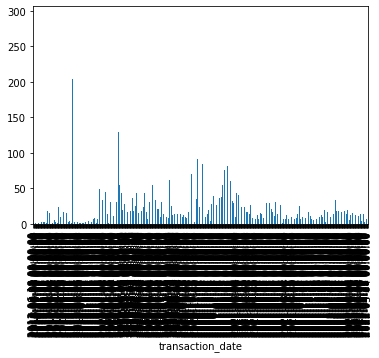

In [251]:
date_group = raw_data_nan.groupby('transaction_date').count()

date_group['disclosure_year'].plot(kind='bar')
#date_group.plot(kind='bar', x='transaction_year')

Well that doesn't look pretty at all, even with the messed up x axis we can kind of see some huge spikes this may be because the transaction dates were not properly recorded? It's weird that there is a massive spike early on and seemingly nothing around the massive spike. I should probably create a column that contains the month, but lets try the years instead

In [270]:
date_group = raw_data_nan.groupby('transaction_date').count()
date_group['disclosure_date'].sort_values(ascending = False)[:20]

transaction_date
2020-03-18    292
2019-06-24    204
2021-02-16    194
2020-11-13    133
2020-04-02    129
2020-02-20    129
2021-02-11    124
2020-10-22     98
2020-11-05     91
2020-03-23     90
2020-11-19     84
2021-02-05     81
2020-04-29     77
2020-01-13     76
2021-01-28     75
2020-08-07     71
2020-10-16     70
2020-03-27     70
2021-01-15     69
2021-02-17     69
Name: disclosure_date, dtype: int64

We can sort of get some sense of the months now

<AxesSubplot:title={'center':'Volume of trades by year'}, xlabel='disclosure_year'>

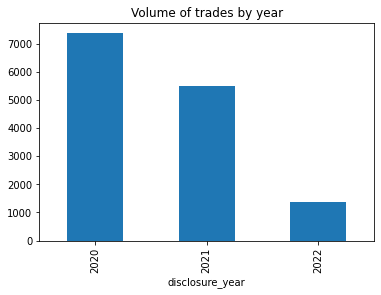

In [254]:
date_group = raw_data_nan.groupby('disclosure_year').count()

date_group['disclosure_date'].plot(kind='bar',
                                   title='Volume of trades by year')

Okay this is pretty interesting we se that there were way more trades in 2020 and 2021 compared to 2022, maybe congressmembers knew something about the direction the economy was heading? 2022 has been a bloodbath so it makes sense why there is less trade compared to the booming markets of 2020 and 2021, later we'll look at whether they were selling or buying.

we can take a quick look at the hottest stocks congressmembers were trading, lets look at the top 10

<AxesSubplot:title={'center':'Top 10 stocks traded'}, xlabel='ticker'>

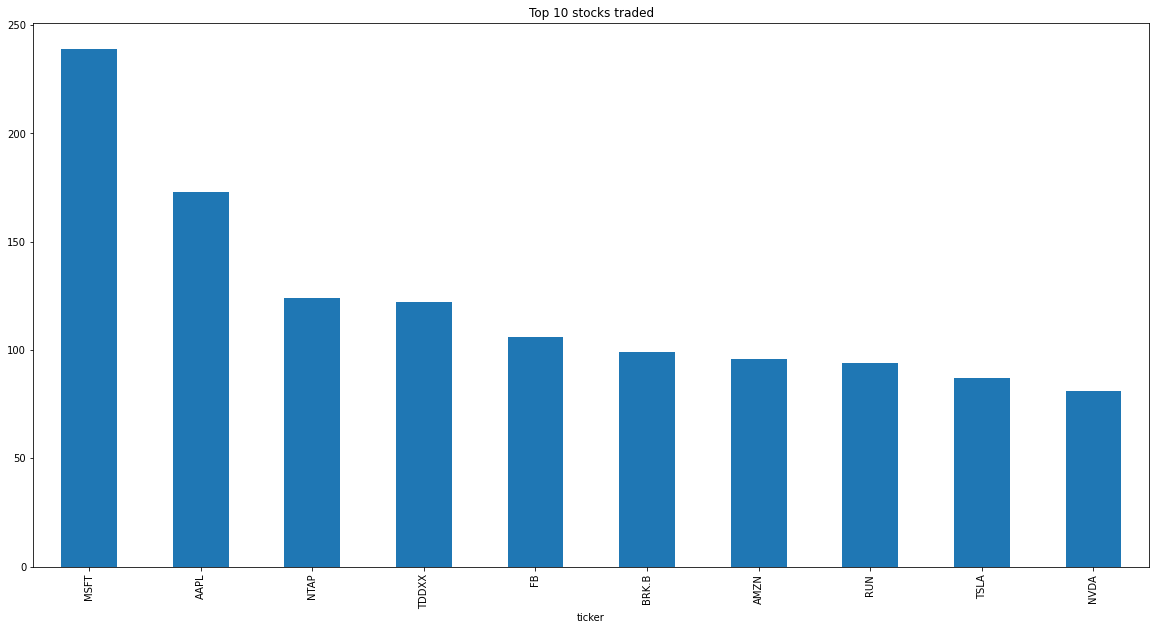

In [291]:
group_stocks = raw_data_nan.groupby('ticker').count()
    .sort_values(by='disclosure_year',ascending=False)
plt.figure(figsize=(20, 10))
group_stocks['disclosure_year'][:10].plot(kind='bar',
                                          title= 'Top 10 stocks traded')

lets take a look at the distribution of types transactions

<AxesSubplot:title={'center':'Distribution of types of transactions'}, xlabel='type'>

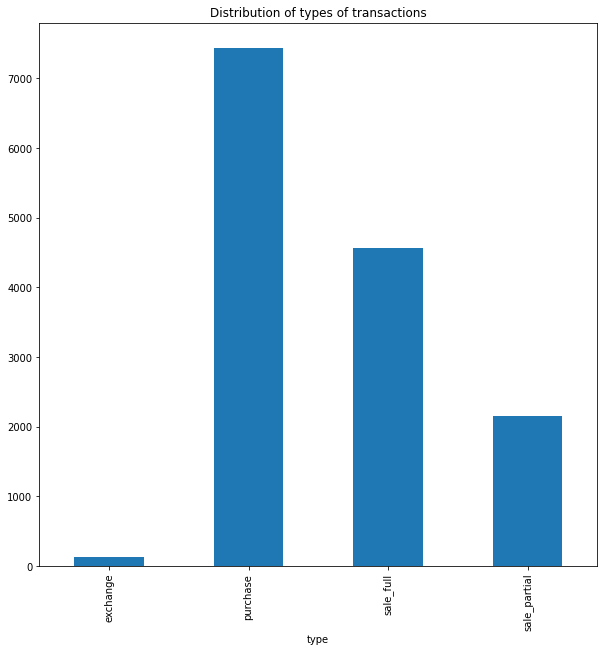

In [290]:
group_types = raw_data_nan.groupby('type').count()
plt.figure(figsize=(10, 10))
group_types['disclosure_year'].plot(kind='bar',
                                    title= 'Distribution of types of transactions')

Let's check real quick to see who is making the most trades!

<AxesSubplot:title={'center':'Top 20 traders'}, xlabel='representative'>

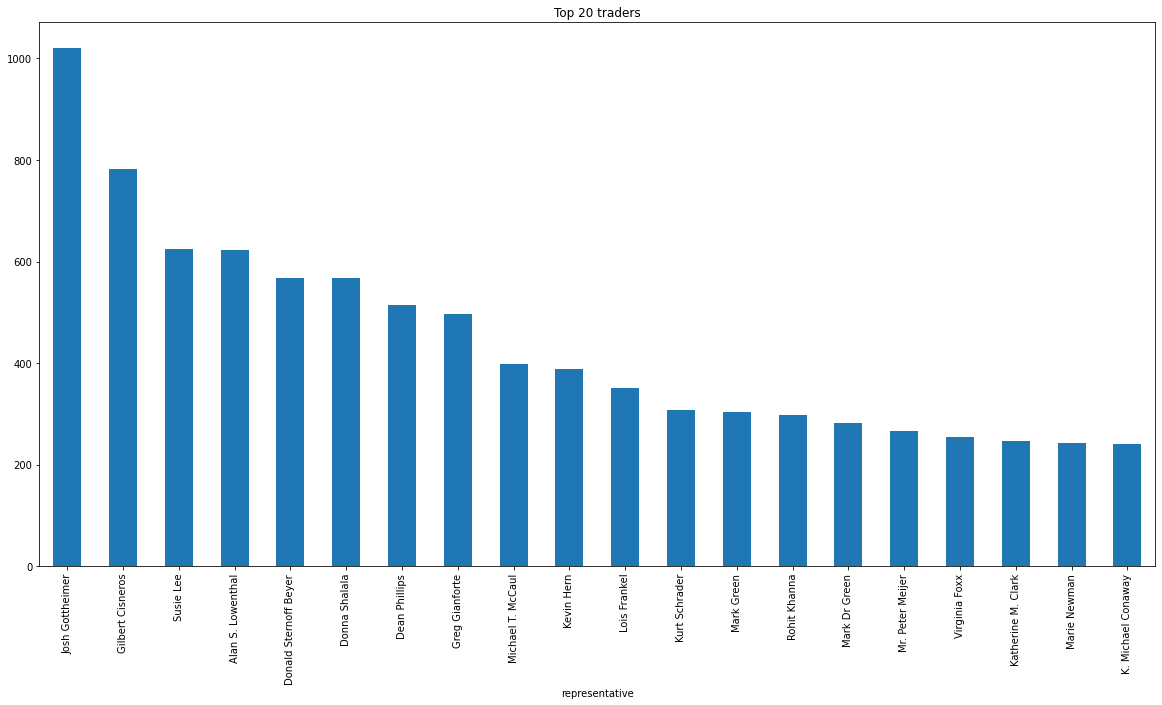

In [286]:
group_rep = raw_data_nan.groupby('representative').count()
    .sort_values(by='disclosure_year',ascending=False)
plt.figure(figsize=(20, 10))
group_rep['disclosure_year'][:20].plot(kind='bar',
                                       title= 'Top 20 traders')

Okay we have some names but maybe in bivariate analysis we can explore how these names relate to party affiliation
and look at proportion

before we dive into bivariate and aggregate analyasis based on party affiliation let's look at distribution of amount ranges

<AxesSubplot:title={'center':'Distribution of of amount ranges'}, xlabel='amount'>

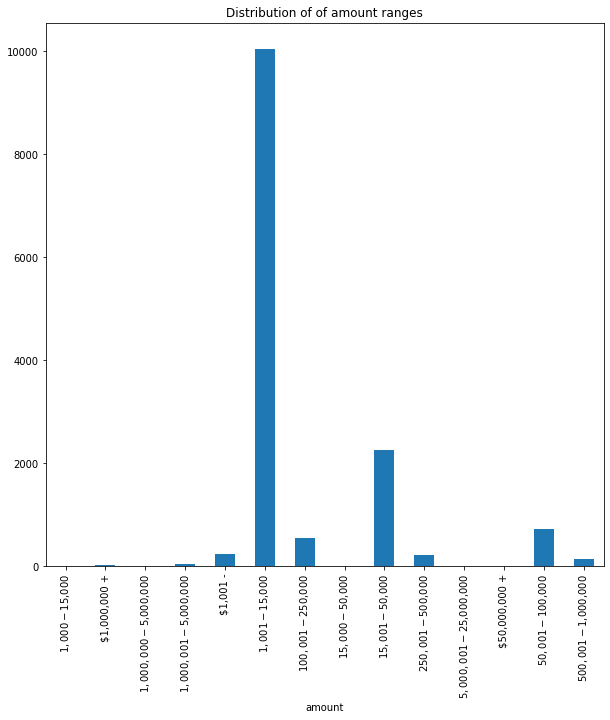

In [283]:
group_amount = raw_data_nan.groupby('amount').count()
plt.figure(figsize=(10, 10))
group_amount['disclosure_year'].plot(kind='bar',
                                    title= 'Distribution of of amount ranges')

We see most trades were in $1,000 to $15,000 but there were a couple that were above $50,000 let's check real quick how many.

In [280]:
group_amount = raw_data_nan.groupby('amount').count()
group_amount['owner']

amount
$1,000 - $15,000               1
$1,000,000 +                  28
$1,000,000 - $5,000,000        0
$1,000,001 - $5,000,000       34
$1,001 -                     232
$1,001 - $15,000            5201
$100,001 - $250,000          272
$15,000 - $50,000              1
$15,001 - $50,000           1216
$250,001 - $500,000          136
$5,000,001 - $25,000,000       8
$50,000,000 +                  1
$50,001 - $100,000           373
$500,001 - $1,000,000        102
Name: owner, dtype: int64

In [279]:
28 + 34 +272 + 136+8+1+373+102

954

As a proportion of all trades these high value trades account for ...

In [281]:
(28 + 34 +272 + 136+8+1+373+102) / group_amount['owner'].sum()

0.12544378698224853

To explore bivariate distributions we'll mainly plot conditional plots based on part affiliation and pivot tables will be nice too let's use out merged data set

In [289]:
merged.head()

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,ptr_link,cap_gains_over_200_usd,full_name,party,last_name
0,2021,10/04/2021,2021-09-27,joint,BP,BP plc,purchase,"$1,001 - $15,000",Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,Virginia Foxx,Republican,Foxx
1,2021,10/04/2021,2021-09-13,joint,XOM,Exxon Mobil Corporation,purchase,"$1,001 - $15,000",Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,Virginia Foxx,Republican,Foxx
2,2021,10/04/2021,2021-09-10,joint,ILPT,Industrial Logistics Properties Trust - Common...,purchase,"$15,001 - $50,000",Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,Virginia Foxx,Republican,Foxx
3,2021,10/04/2021,2021-09-28,joint,PM,Phillip Morris International Inc,purchase,"$15,001 - $50,000",Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,Virginia Foxx,Republican,Foxx
4,2021,10/04/2021,2021-09-17,self,BLK,BlackRock Inc,sale_partial,"$1,001 - $15,000",Alan S. Lowenthal,CA47,https://disclosures-clerk.house.gov/public_dis...,False,Alan S. Lowenthal,Democratic,Lowenthal


lets revisit the top 10 stocks based on party affiliation

<AxesSubplot:title={'center':'Top 10 stocks traded'}, xlabel='ticker'>

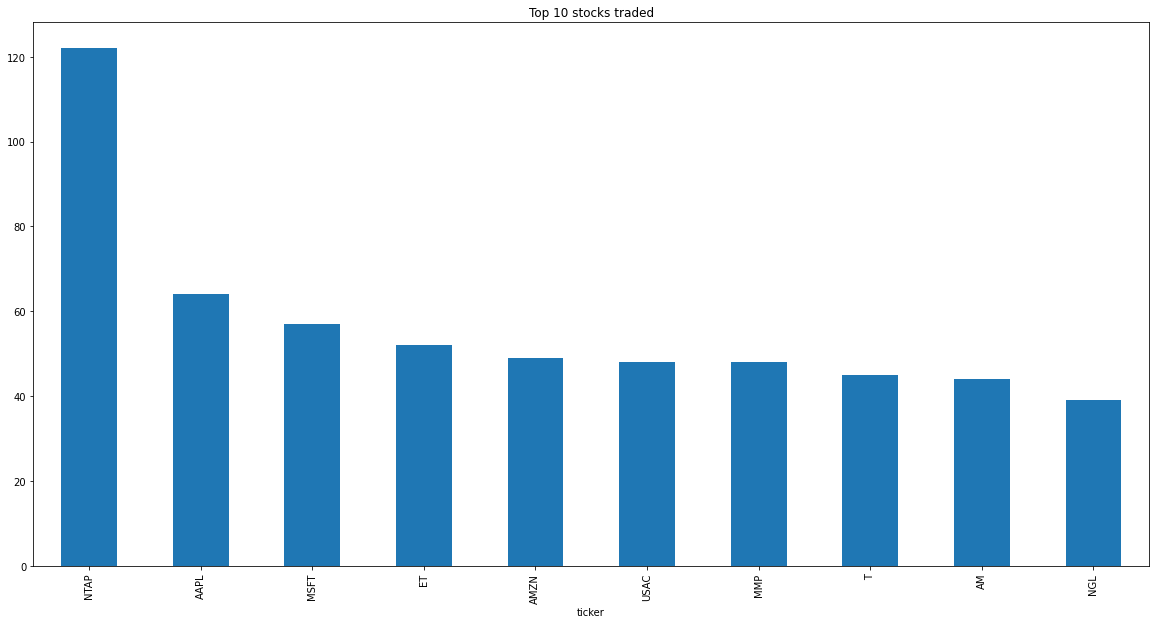

In [306]:
group_stocks = merged[merged['party'] == 'Republican']
    .groupby('ticker').count().sort_values(by='disclosure_year',
                                           ascending=False)
plt.figure(figsize=(20, 10))
group_stocks['disclosure_year'][:10].plot(kind='bar',
                                          title= 'Top 10 stocks traded for Republicans')

<AxesSubplot:title={'center':'Top 10 stocks traded for Democrats'}, xlabel='ticker'>

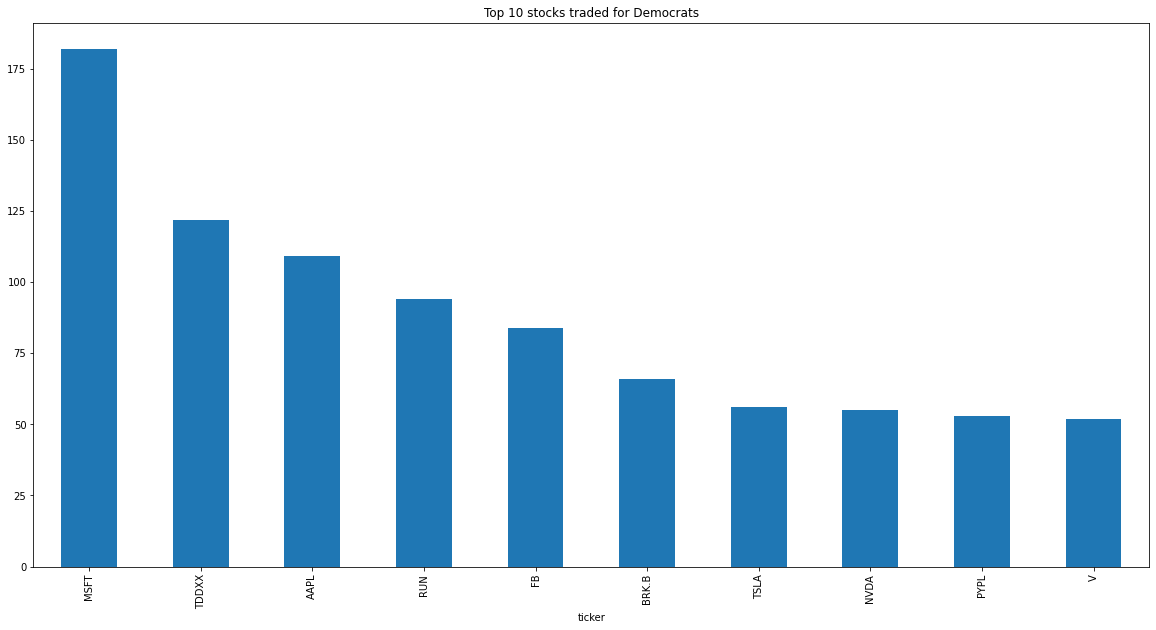

In [308]:
group_stocks = merged[merged['party'] == 'Democratic']
    .groupby('ticker').count().sort_values(by='disclosure_year',ascending=False)
plt.figure(figsize=(20, 10))
group_stocks['disclosure_year'][:10].plot(kind='bar',
                                          title= 'Top 10 stocks traded for Democrats')

This is pretty intersting among the top 10 only apple and microsoft are shared amongst the top 10 stocks, 
We see for republicans there are sort of older well established tech and traditional energy while democrats are trading new tech,solar energy, and blackrock + berkshire

Let's see which party makes more trades

In [ ]:
merged.sort_values(by='pivot_table(index='')

In [331]:
group_rep = raw_data_nan.groupby('representative').count()
    .sort_values(by='disclosure_year',ascending=False)
all_trades = pd.DataFrame(group_rep['disclosure_year'])
    .merge(congress_party,left_index = True, right_on='full_name', how='left')
all_trades.groupby('party')['disclosure_year'].sum() / raw_data_nan.shape[0]

party
Democratic    0.638434
Republican    0.361566
Name: disclosure_year, dtype: float64

In [ ]:
merged.pivot_table(index='party',columns='')

Okay so we observe from the data that Democrats tend to trade more, how extreme is this value, could this be due to chance? I think I'll hypothesis test if the distribution of trades comes from a null distribution of 50% / 50% from each party, we will visit this later 

Lets look at the type of trades congressmembers make based on party affiliation

In [333]:
types = merged.pivot_table(index='party',columns = 'type',
                           values='representative',aggfunc='count')
types

type,exchange,purchase,sale_full,sale_partial
party,,,,
Democratic,57,4373,2925,1758
Republican,71,3055,1638,397


We can clearly see much more buying and much more selling from democrats but lets dig a bit deeper

Okay this is interesting, let's extend this to also see the types of trades within years as proportions

In [385]:
types = merged.pivot_table(index='party',columns = ['type','disclosure_year']
                           ,values='representative',aggfunc='count')
types / types.sum(axis=0)

type            exchange                 purchase                      \
disclosure_year     2020      2021 2022      2020      2021      2022   
party                                                                   
Democratic       0.43956  0.518519  0.3  0.601844  0.583416  0.543417   
Republican       0.56044  0.481481  0.7  0.398156  0.416584  0.456583   

type            sale_full                     sale_partial                      
disclosure_year      2020      2021      2022         2020      2021      2022  
party                                                                           
Democratic       0.713609  0.548747  0.634529     0.820954  0.822653  0.760976  
Republican       0.286391  0.451253  0.365471     0.179046  0.177347  0.239024

We can see that the majority of purchases were conducted in 2020 and 2021 amongst both parties and that democratic congress members participated in much more selling activity both full and partialy. Okay we can see they participate in more raw number of trades but what about the actual amount of money?

In [388]:
types = merged.pivot_table(columns='party',index = ['type','amount']
                           ,values='representative',aggfunc='count')
types 

party                                  Democratic  Republican
type         amount                                          
exchange     $1,000,001 - $5,000,000          NaN         1.0
             $1,001 -                         1.0         NaN
             $1,001 - $15,000                44.0        17.0
             $100,001 - $250,000              1.0         9.0
             $15,001 - $50,000                6.0        15.0
             $250,001 - $500,000              2.0         7.0
             $50,001 - $100,000               3.0        21.0
             $500,001 - $1,000,000            NaN         1.0
purchase     $1,000,000 +                     9.0         NaN
             $1,000,001 - $5,000,000         17.0         2.0
             $1,001 -                        88.0         5.0
             $1,001 - $15,000              3567.0      1626.0
             $100,001 - $250,000             47.0       230.0
             $15,001 - $50,000              461.0       814.0
             $250,001 - $500,000             36.0        59.0
             $5,000,001 - $25,000,000         4.0         NaN
             $50,001 - $100,000              90.0       301.0
             $500,001 - $1,000,000           54.0        18.0
sale_full    $1,000 - $15,000                 NaN         3.0
             $1,000,000 +                    12.0         1.0
             $1,000,000 - $5,000,000          NaN         1.0
             $1,000,001 - $5,000,000         11.0         4.0
             $1,001 -                        21.0         1.0
             $1,001 - $15,000              2267.0       826.0
             $100,001 - $250,000             62.0       156.0
             $15,000 - $50,000                NaN         2.0
             $15,001 - $50,000              369.0       415.0
             $250,001 - $500,000             52.0        58.0
             $5,000,001 - $25,000,000         2.0         1.0
             $50,000,000 +                    NaN         1.0
             $50,001 - $100,000             102.0       144.0
             $500,001 - $1,000,000           27.0        25.0
sale_partial $1,000 - $15,000                 NaN         1.0
             $1,000,000 +                     6.0         NaN
             $1,000,001 - $5,000,000          3.0         NaN
             $1,001 -                       126.0         NaN
             $1,001 - $15,000              1472.0       235.0
             $100,001 - $250,000             20.0        20.0
             $15,000 - $50,000                NaN         1.0
             $15,001 - $50,000               80.0        98.0
             $250,001 - $500,000             10.0         3.0
             $5,000,001 - $25,000,000         2.0         NaN
             $50,001 - $100,000              23.0        38.0
             $500,001 - $1,000,000           16.0         1.0

 There are some baffling findings, when looking at the $500,000+ trades we clearly see that democrats engage in far more high value trades compared to republicans aside from the one republican trade for more than $50,000,000.
Due to the coarse granularity of the amount variable it is definitely a limiting factor in unlocking this particular data set but it is still better than nothing.

### Assessment of Missingness

During the EDA phase I noticed that the owner columns had almost half of it's values missing. Thinking about it, it could potentially be NMAR maybe if the transaction would appear shady based on a certian value it could look bad for the congressmember, so they just don't report it at all. But we should conduct an appropriate MAR test to see if there is actually dependence on other columns, it could very well be the case the maybe party affiliation, type of trade, or amount of trade could be valid variables that influence whether the owner variable is missing so we'll conduct some MAR tests.Given the categorical nature of most columns, we will mostly use tvd as the test statistic. We will use 0.01 significance level.

observed tvd:  0.08209972663413961


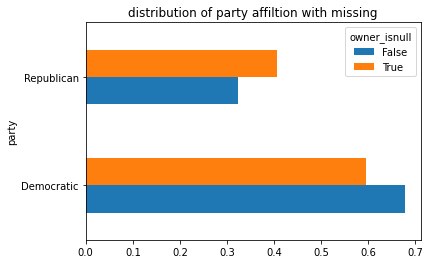

In [372]:
merged['owner_isnull'] = merged['owner'].isna()


emp_distributions = (
    merged
    .pivot_table(columns='owner_isnull', index='party',
                 aggfunc='size')
    .fillna(0)
    .apply(lambda x:x / x.sum())
)

emp_distributions.plot(kind='barh', title='distribution of party affiltion with missing');

observed_tvd = np.sum(np.abs(emp_distributions.diff(axis=1)
                             .iloc[:,-1])) / 2
print('observed tvd: ', observed_tvd)


n_repetitions = 500

merged_type = merged.copy()[['party', 'owner_isnull']]
tvds = []
for _ in range(n_repetitions):
    
    shuffled_types = (
        merged_type['party']
        .sample(replace=False, frac=1)
        .reset_index(drop=True)
    )
    
    shuffled = (
        merged_type
        .assign(**{'Shuffled Types': shuffled_types})
    )
    
    # compute the tvd
    shuffed_emp_distributions = (
        shuffled
        .pivot_table(columns='owner_isnull', index='Shuffled Types',
                     values=None, aggfunc='size')
        .fillna(0)
        .apply(lambda x:x/x.sum())
    )
    
    tvd = np.sum(np.abs(shuffed_emp_distributions.diff(axis=1).iloc[:,-1])) / 2
    # add it to the list of results
    
    tvds.append(tvd)

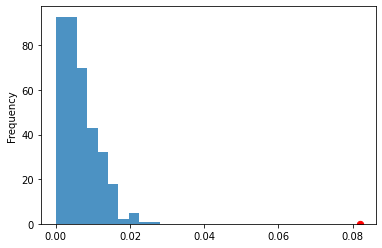

In [373]:
pd.Series(tvds).plot(kind='hist', density=True, alpha=0.8)
plt.scatter(observed_tvd, 0, color='red', s=40);

In [374]:
pval = np.mean(tvds >= observed_tvd)
pval

0.0

observed tvd:  0.05289456382573785


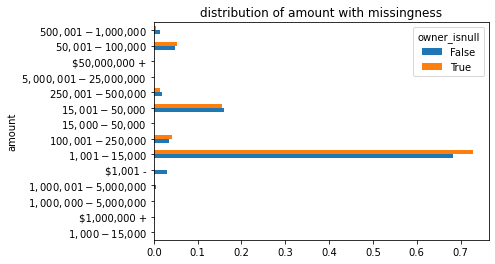

In [375]:
merged['owner_isnull'] = merged['owner'].isna()


emp_distributions = (
    merged
    .pivot_table(columns='owner_isnull', index='amount',
                 aggfunc='size')
    .fillna(0)
    .apply(lambda x:x / x.sum())
)

emp_distributions.plot(kind='barh',
                       title='distribution of amount with missingness');

observed_tvd = np.sum(np.abs(emp_distributions.diff(axis=1).iloc[:,-1])) / 2
print('observed tvd: ', observed_tvd)

n_repetitions = 500

payments_type = merged.copy()[['amount', 'owner_isnull']]
tvds = []
for _ in range(n_repetitions):
    
    shuffled_types = (
        payments_type['amount']
        .sample(replace=False, frac=1)
        .reset_index(drop=True)
    )
    
    shuffled = (
        payments_type
        .assign(**{'Shuffled Types': shuffled_types})
    )
    
    # compute the tvd
    shuffed_emp_distributions = (
        shuffled
        .pivot_table(columns='owner_isnull', index='Shuffled Types',
                     values=None, aggfunc='size')
        .fillna(0)
        .apply(lambda x:x/x.sum())
    )
    
    tvd = np.sum(np.abs(shuffed_emp_distributions.diff(axis=1).iloc[:,-1])) / 2
    # add it to the list of results
    
    tvds.append(tvd)

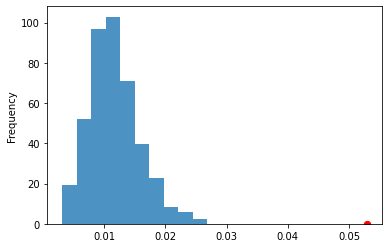

In [376]:
pd.Series(tvds).plot(kind='hist', density=True, alpha=0.8)
plt.scatter(observed_tvd, 0, color='red', s=40);

In [377]:
pval = np.mean(tvds >= observed_tvd)
pval

0.0

observed_tvd 0.07241542383242788


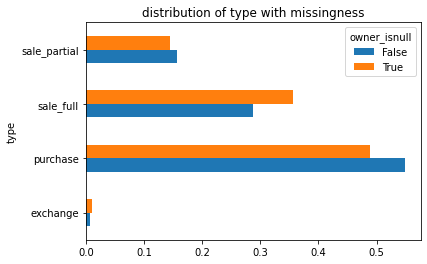

In [381]:
merged['owner_isnull'] = merged['owner'].isna()


emp_distributions = (
    merged
    .pivot_table(columns='owner_isnull', index='type', aggfunc='size')
    .fillna(0)
    .apply(lambda x:x / x.sum())
)

emp_distributions.plot(kind='barh',
                       title='distribution of type with missingness');

observed_tvd = np.sum(np.abs(emp_distributions.diff(axis=1)
                             .iloc[:,-1])) / 2
print('observed_tvd', observed_tvd)

n_repetitions = 500

merged_type = merged.copy()[['type', 'owner_isnull']]
tvds = []
for _ in range(n_repetitions):
    
    shuffled_types = (
        merged_type['type']
        .sample(replace=False, frac=1)
        .reset_index(drop=True)
    )
    
    shuffled = (
        merged_type
        .assign(**{'Shuffled Types': shuffled_types})
    )
    
    # compute the tvd
    shuffed_emp_distributions = (
        shuffled
        .pivot_table(columns='owner_isnull', index='Shuffled Types',
                     values=None, aggfunc='size')
        .fillna(0)
        .apply(lambda x:x/x.sum())
    )
    
    tvd = np.sum(np.abs(shuffed_emp_distributions.diff(axis=1).iloc[:,-1])) / 2
    # add it to the list of results
    
    tvds.append(tvd)
    
    


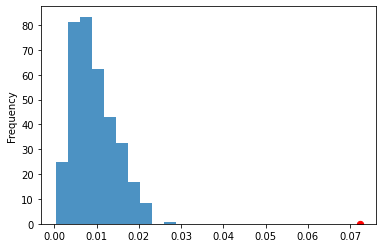

In [382]:
pd.Series(tvds).plot(kind='hist', density=True, alpha=0.8)
plt.scatter(observed_tvd, 0, color='red', s=40);

In [383]:
pval = np.mean(tvds >= observed_tvd)
pval

0.0

Even with significane level of 0.01 we see from all three MAR permutation tests that the observed total variation distance among variables party, amount, and type are all much greater than the repective null distribution generated by permutation tests. In all three cases the null hypothesis that these tvd's come from the same distribution is rejected in favor of alternative hypothesis that they come from different distributions. Because these tvd's do not come from the same distributions that means there is a MAR dependence of owner on these variables. After obtaining MAR dependence varification from permutation testing we can think how intuitevely these variables migh influence the probability that the owner column is missing. In terms of party it could be due to that fact that one party or the other might tend to report less or more often, for amount maybe the amount a very large transaction might have a higher probability to report owner because it could appear shady or might not want to diclose the ownership of the position based on size. For the type it could be maybe that buys or sells are over or under reported so as not to appear to buy or sell in a motivated fashion in which the ownership could hint at the scope of those involved.

### Hypothesis Testing

Let's further explore the distribution behind the proportion of trades made between party affiliations, the test statistic of interest is the signed difference between the proportions, we'll use democrats - rep, my proposed null hypothesis is a world in which I would think both parties of interest would have an equal interest in trading so the proportion of trades from democrats is around 50% and the proportion of trades from republicans is around 50% we might expect our test statistic to be close to zero under our null. My alternative hypothesis is that we live in a world where democrats are more interested in trading, so the proportion of trades from democrats is above 50% and republicans trade less that 50% of the time yeilding a test statistic that is positive because, dem % - rep % would expect higher number of dem % trades. We will use 0.01 significance level.

In [339]:
observed = all_trades.groupby('party')['disclosure_year'].sum() / raw_data_nan.shape[0]
observed = observed[0] - observed[1]
observed

0.2768670309653916

I think this test might be too easy but I have other homework and I think it answers an honest question so we'll go ahead

In [345]:
N = 10000

# 10000 times, we want to 'flip a coin' the size of original data set times
results = []
for _ in range(N):
    simulation = np.random.choice([0, 1], p=[0.5, 0.5], size=merged.shape[0]) # 0 will represent dems, 1 repubs
    party_prop_diff = (simulation == 0).mean() - (simulation == 1).mean()  # Test statistic
    results.append(party_prop_diff)

In [346]:
results

[-0.013310914950259267,
 -0.001961608518985525,
 -0.005884825556956741,
 0.0,
 -0.004763906403250695,
 -0.012189995796553221,
 0.015973097940311043,
 0.003502872355331421,
 0.0025220680958386033,
 -0.003502872355331421,
 -0.005464480874316946,
 -0.008547008547008517,
 0.01429171920975203,
 0.015973097940311043,
 0.0044836766148241836,
 -0.008126663864368833,
 -0.008547008547008517,
 0.0009808042594927624,
 0.0030825276726915707,
 0.009387697912288051,
 0.007285974499089243,
 -0.0007005744710662509,
 0.009527812806501279,
 -0.00028022978842651147,
 0.007566204287515754,
 -0.007285974499089243,
 0.007846434075942321,
 -0.0037831021437579326,
 -0.008406893652795289,
 0.0023819532016253753,
 -0.0001401148942132835,
 -0.010648731960207325,
 0.0007005744710662509,
 -0.0023819532016253753,
 -0.008266778758582005,
 0.015973097940311043,
 -0.005464480874316946,
 0.0001401148942132835,
 -0.010928961748633892,
 0.0086871234412218,
 -0.014151604315538746,
 -0.003502872355331421,
 -0.01443183410396

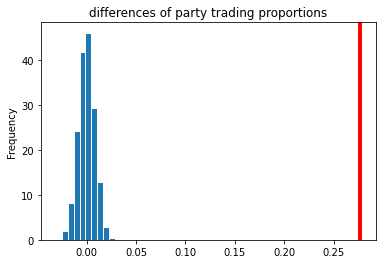

In [347]:
pd.Series(results).plot(kind='hist', 
                        density=True,
                        ec='w',
                        title='differences of party trading proportions');
plt.axvline(x=observed, color='red', linewidth=4);

In [348]:
p_val = (results >= observed).mean()
p_val

0.0

It was pretty obvious from the graph but this difference in proportions is definitely not a feasible occurance under the null hypothesis even with an extreme significance level of 0.01. Based on the p value of zero we will reject the null hypothesis that the interest of trading is evenly divided among republicans and democrats in favor of the alternative that democrats are more interested in trading than republicans.